In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose



In [2]:
df=pd.read_csv('credit_card_transactions.csv')

In [3]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [4]:
df['is_fraud'].value_counts()

is_fraud
0    884987
1      5065
Name: count, dtype: int64

# Feature Extraction

In [5]:
#Remove irrelevant columns, duplicate rows, and null values
df=df.drop(['cc_num', 'first','last','trans_num','unix_time','street'], axis=1)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

## Time, age, distance

In [6]:
#Process time data
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y/%m/%d %H:%M')

df['year'] = df['trans_date_trans_time'].dt.year
df['month'] = df['trans_date_trans_time'].dt.month
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday  # (0=Monday, 6=Sunday)
df['hour'] = df['trans_date_trans_time'].dt.hour

In [7]:
#The cardholder's age at the time of the transaction
df['dob'] = pd.to_datetime(df['dob'], format=r'%Y/%m/%d')
df['cardholder_age'] = df.apply(
    lambda row: 2019 - row['dob'].year if row['year'] == 2019 else 2020 - row['dob'].year, 
    axis=1
)

#Process merchant name
df['merchant']=df['merchant'].apply(lambda x:x[6:]) 

In [8]:
# Calculate the distance between the merchant and the transaction based on longitude and latitude

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # The radius of the Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

df['distance'] = df.apply(lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

## Zip codes, state, city, population, and population density

In [9]:
# Read a csv of zip codes for US states and cities
zip_data = pd.read_csv('uszips.csv')

# Process zip codes in the dataset
df['merch_zipcode'] = df['merch_zipcode'].astype(str).str.zfill(5)
df['merch_zipcode']=df['merch_zipcode'].apply(lambda x:str(int(float(x))))
zip_data['city_zip'] = zip_data['city_zip'].astype(str).str.zfill(5)
df['zip'] = df['zip'].astype(str).str.zfill(5)

zip_data = zip_data[['city_zip', 'state_name', 'city_name', 'population', 'density']].drop_duplicates()

In [10]:
# Extract merchants' state and city
df = df.merge(zip_data, 
              left_on='merch_zipcode', 
              right_on='city_zip', 
              how='left').drop(columns=['city_zip'])

df.rename(columns={'state_name': 'merch_state', 'city_name': 'merch_city',
                   'population': 'merch_pop','density': 'merch_dens'}, inplace=True)

In [11]:
# Extract cardholders' state and city
df = df.merge(zip_data, 
              left_on='zip', 
              right_on='city_zip', 
              how='left').drop(columns=['city_zip'])

df.rename(columns={'state_name': 'holder_state', 'city_name': 'holder_city',
    'population': 'holder_pop','density': 'holder_dens'}, inplace=True)

In [12]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [13]:
pd.set_option('display.max_columns', None)
df.head(2)

,trans_date_trans_time,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,is_fraud,merch_zipcode,year,month,day,weekday,hour,cardholder_age,distance,merch_state,merch_city,merch_pop,merch_dens,holder_state,holder_city,holder_pop,holder_dens
0,2019-01-01,"Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,36.011293,-82.048315,0,28705,2019,1,1,1,0,31,78.597568,North Carolina,Bakersville,6708.0,20.9,North Carolina,Moravian Falls,3142.0,19.8
1,2019-01-01,Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,43.150704,-112.154481,0,83236,2019,1,1,1,0,57,108.206083,Idaho,Firth,2018.0,3.6,Idaho,Malad City,4546.0,2.4


# Exploratory Data Analysis

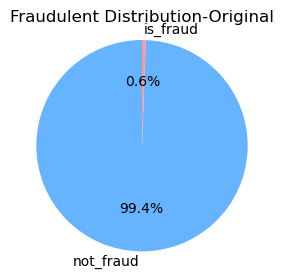

In [4]:
gender_counts = df['is_fraud'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(gender_counts, labels=['not_fraud','is_fraud'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Fraudulent Distribution-Original')
plt.axis('equal') 
plt.show()

## Date & Time

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_7596\2465749492.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='year', data=df, palette='Set2')


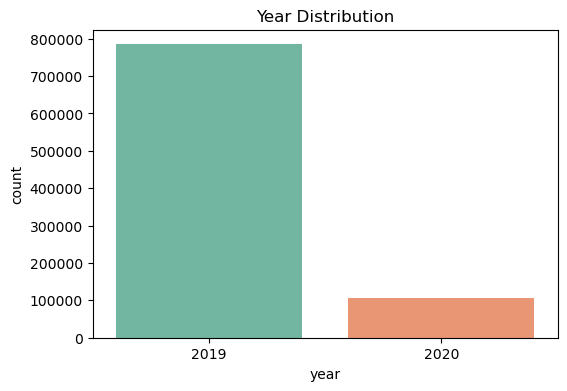

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='year', data=df, palette='Set2')
plt.title('Year Distribution')
plt.show()

In [6]:
data_2019=df[df['year']==2019]
data_2020=df[df['year']==2020]

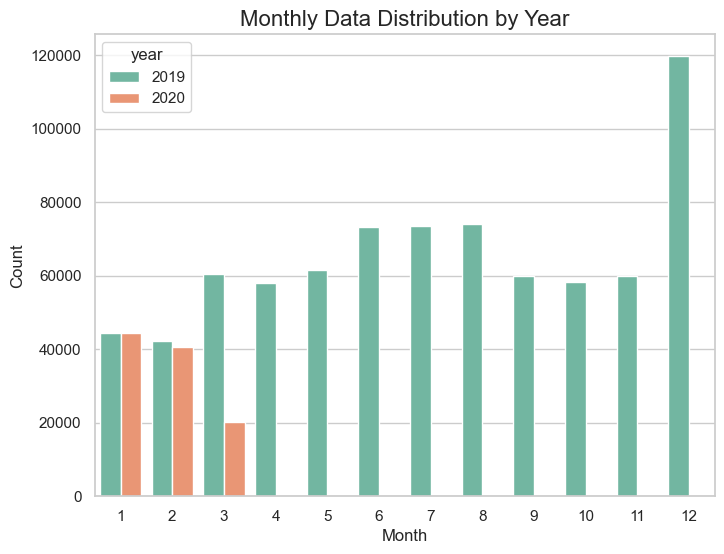

In [41]:
monthly_counts = df.groupby(['year', 'month']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(x='month', y='count', hue='year', data=monthly_counts, palette='Set2')

plt.title('Monthly Data Distribution by Year', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

In [13]:
df_fraud=df[df['is_fraud']==1]

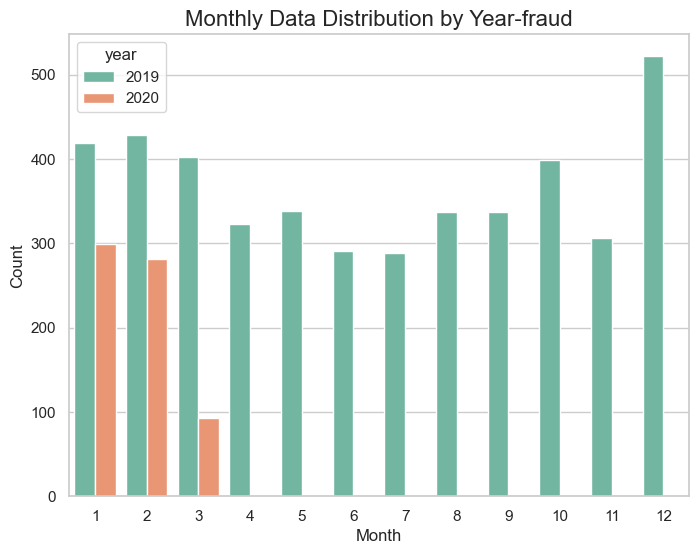

In [40]:
monthly_counts = df_fraud.groupby(['year', 'month']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(x='month', y='count', hue='year', data=monthly_counts, palette='Set2')
plt.title('Monthly Data Distribution by Year-fraud', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

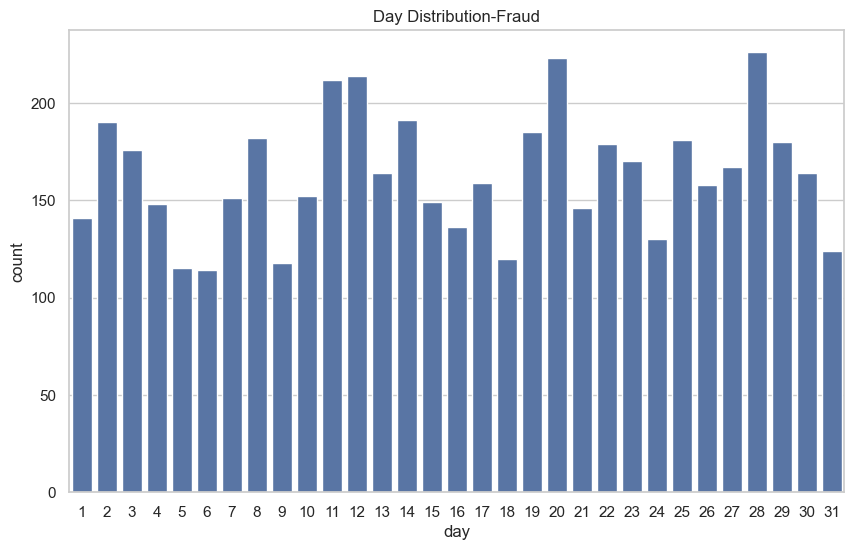

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='day', data=df_fraud)
plt.title('Day Distribution-Fraud')
plt.show()

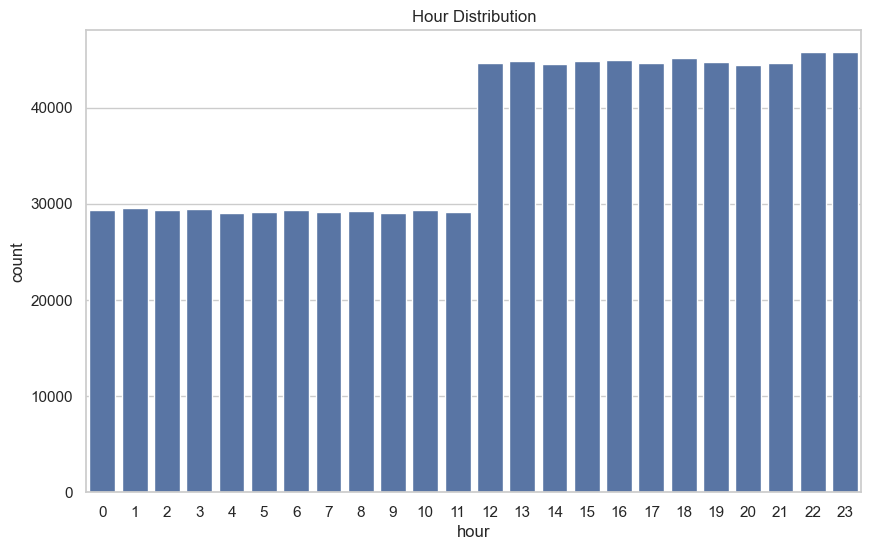

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df)
plt.title('Hour Distribution')
plt.show()

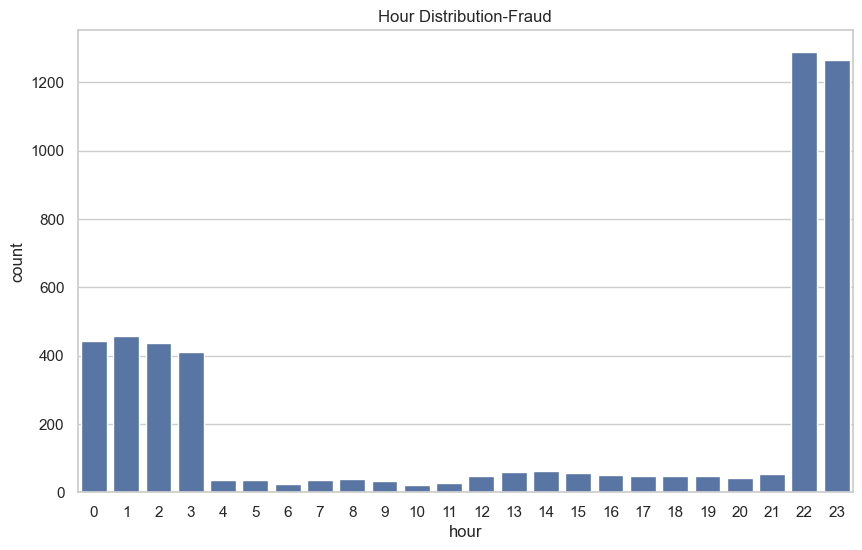

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df_fraud)
plt.title('Hour Distribution-Fraud')
plt.show()

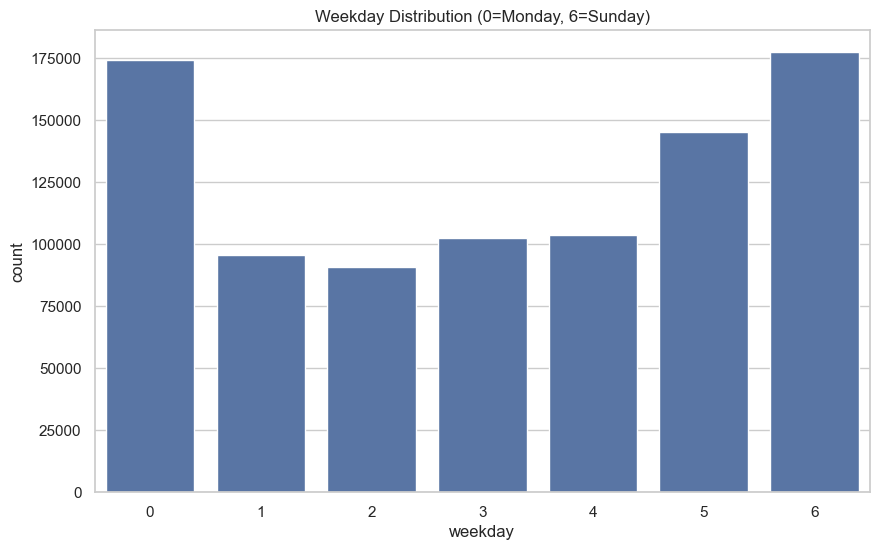

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='weekday', data=df)
plt.title('Weekday Distribution (0=Monday, 6=Sunday)')
plt.show()

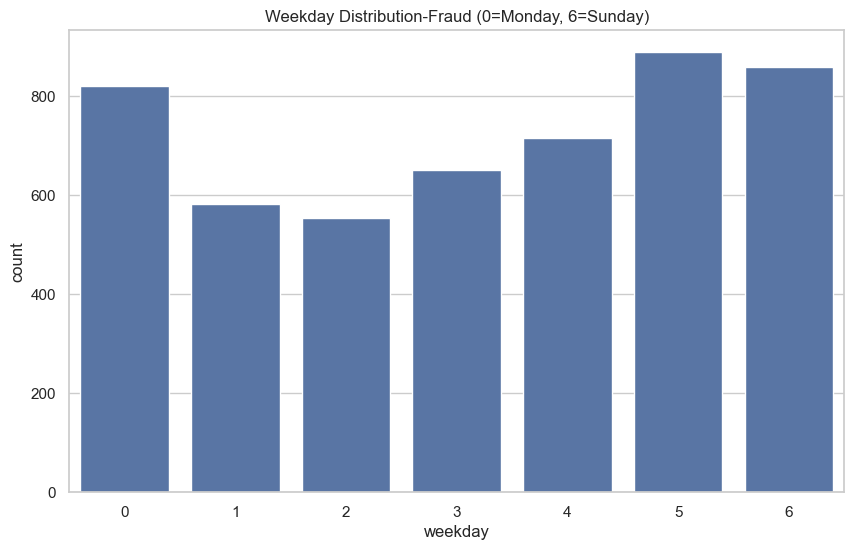

In [22]:
plt.figure(figsize=(10, 6))
sns.countplot(x='weekday', data=df_fraud)
plt.title('Weekday Distribution-Fraud (0=Monday, 6=Sunday)')
plt.show()

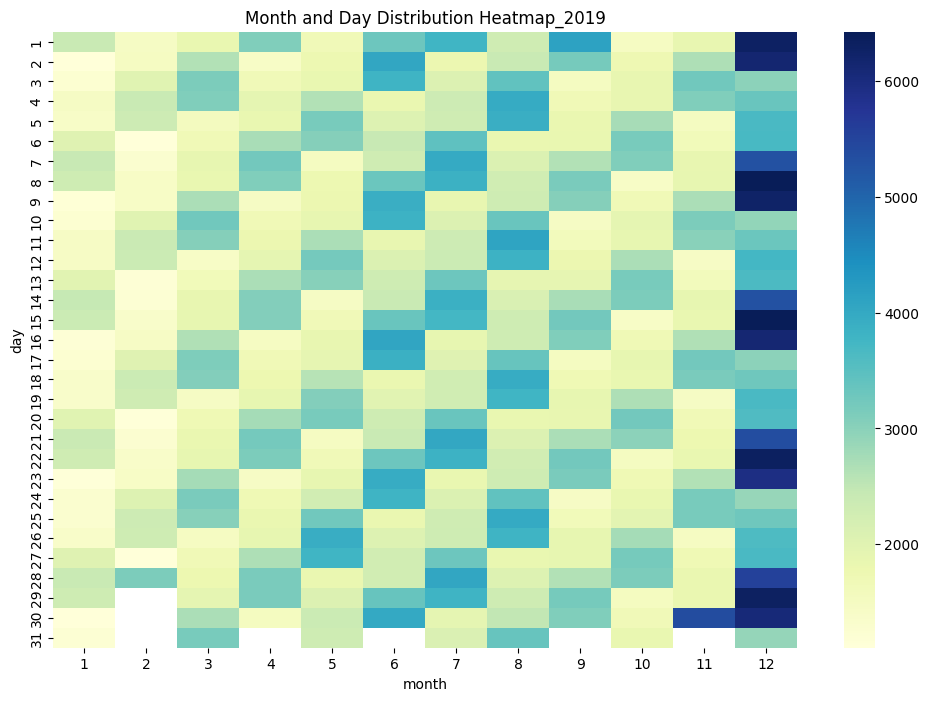

In [37]:

hour_day_distribution = data_2019.groupby(['day', 'month']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Month and Day Distribution Heatmap_2019')
plt.show()

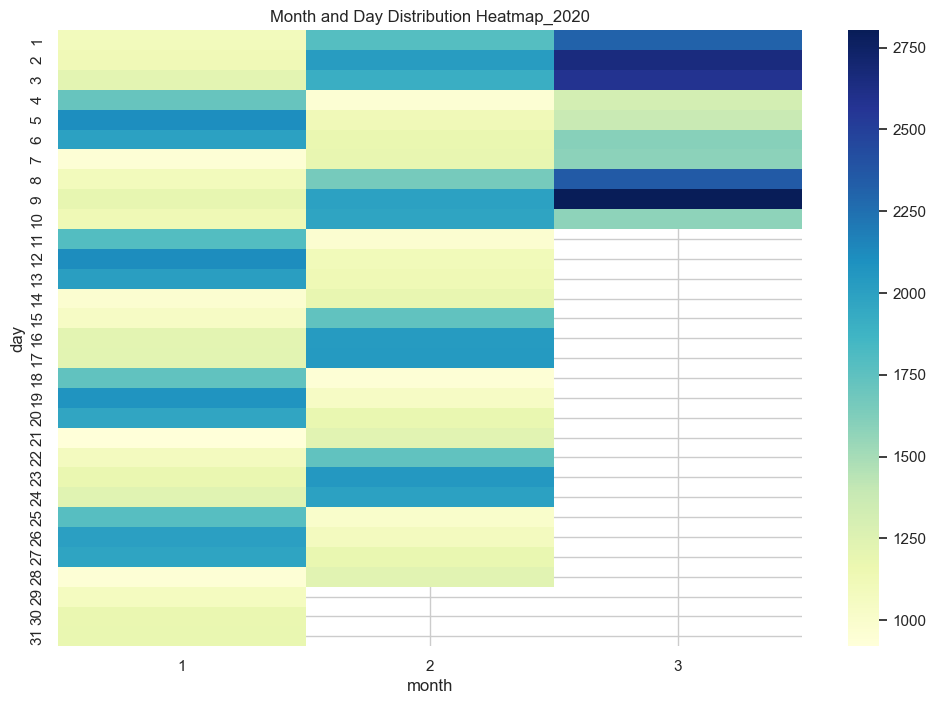

In [51]:

hour_day_distribution = data_2020.groupby(['day', 'month']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Month and Day Distribution Heatmap_2020')
plt.show()

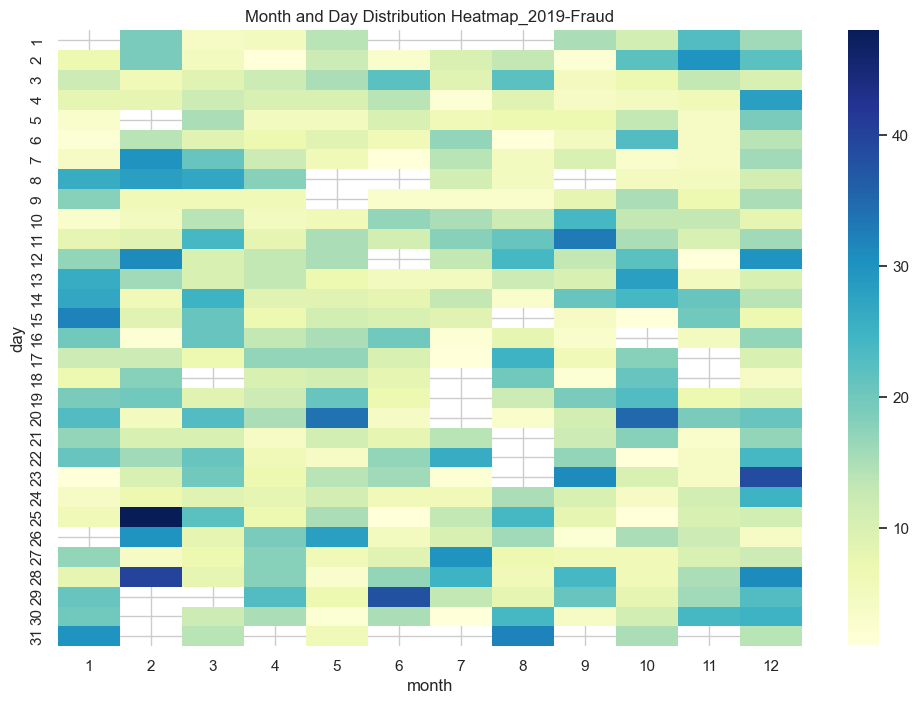

In [52]:
data_2019_fraud=data_2019[data_2019['is_fraud']==1]

hour_day_distribution = data_2019_fraud.groupby(['day', 'month']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Month and Day Distribution Heatmap_2019-Fraud')
plt.show()

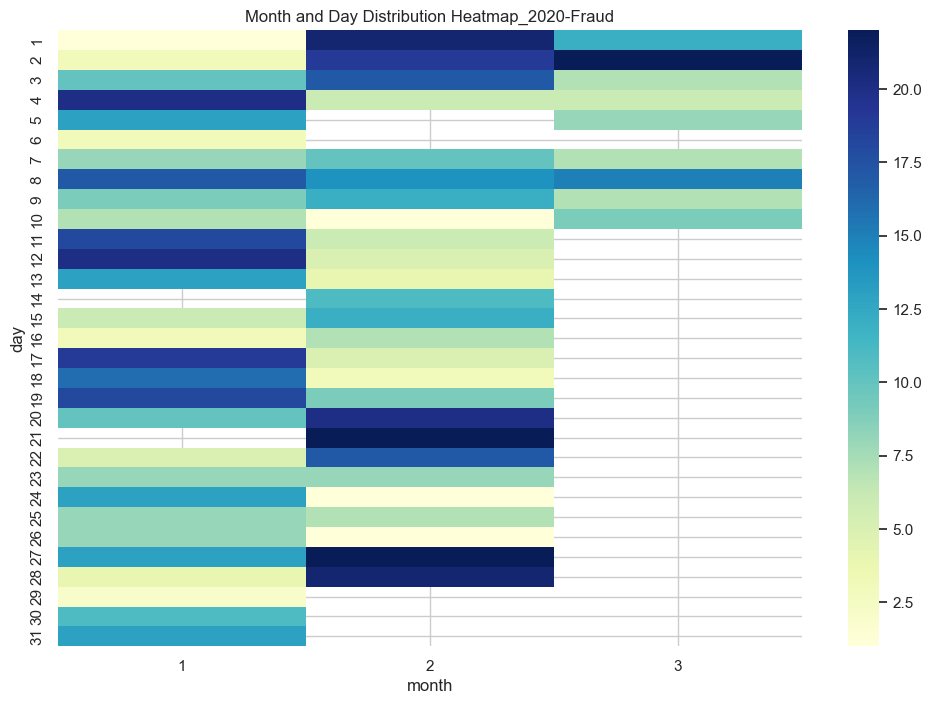

In [53]:
data_2020_fraud=data_2020[data_2020['is_fraud']==1]

hour_day_distribution = data_2020_fraud.groupby(['day', 'month']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Month and Day Distribution Heatmap_2020-Fraud')
plt.show()


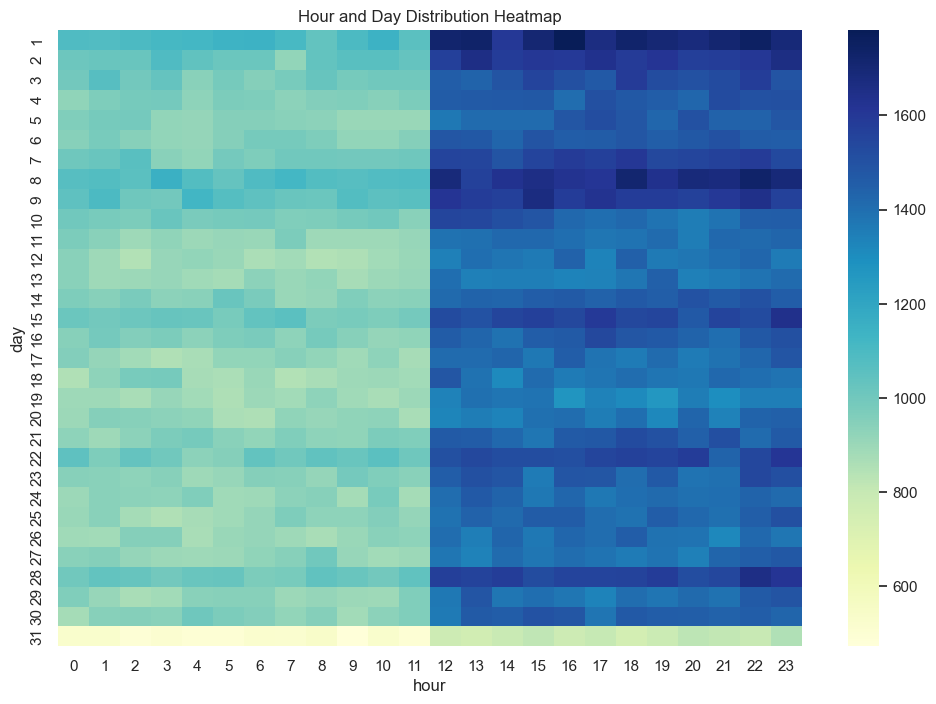

In [28]:
hour_day_distribution = df.groupby(['day', 'hour']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Hour and Day Distribution Heatmap')
plt.show()

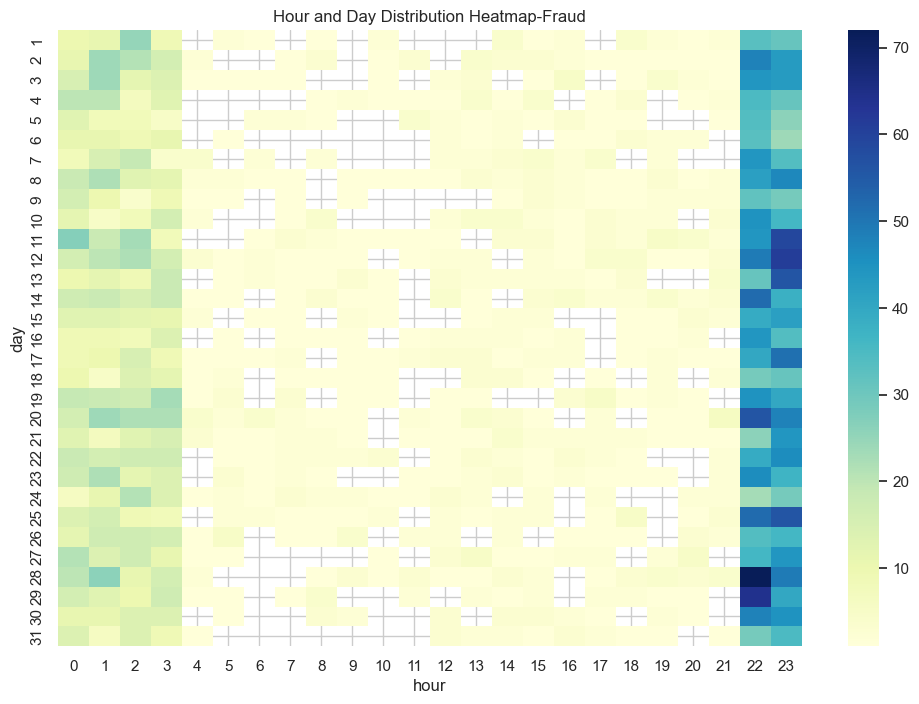

In [29]:
hour_day_distribution = df_fraud.groupby(['day', 'hour']).size().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hour_day_distribution, cmap="YlGnBu")
plt.title('Hour and Day Distribution Heatmap-Fraud')
plt.show()

## Time Series Analysis

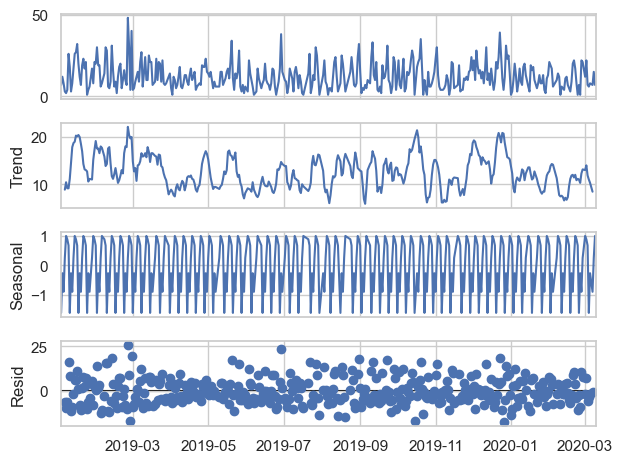

In [55]:
daily_counts = df_fraud.groupby(df_fraud['trans_date_trans_time'].dt.date).size()
daily_counts.index = pd.to_datetime(daily_counts.index)  
daily_counts = daily_counts.sort_index()  

result = seasonal_decompose(daily_counts, model='additive', period=7)  
result.plot()
plt.show()

trend = result.trend
seasonal = result.seasonal
resid = result.resid


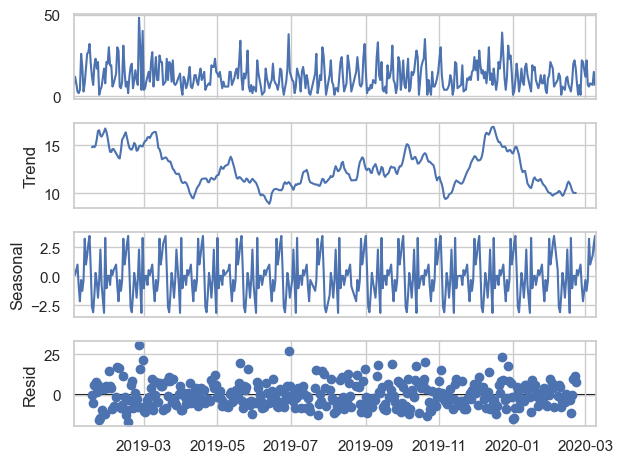

In [50]:

result = seasonal_decompose(daily_counts, model='additive', period=30) 
result.plot()
plt.show()

trend = result.trend
seasonal = result.seasonal
resid = result.resid

## Category & Merchant

In [8]:
print(df['merchant'].value_counts())

merchant
fraud_Kilback LLC                       2993
fraud_Cormier LLC                       2537
fraud_Schumm PLC                        2490
fraud_Boyer PLC                         2410
fraud_Kuhn LLC                          2384
                                        ... 
fraud_Douglas, DuBuque and McKenzie      527
fraud_Medhurst, Labadie and Gottlieb     524
fraud_Reichert-Weissnat                  521
fraud_Satterfield-Lowe                   516
fraud_Hahn, Douglas and Schowalter       497
Name: count, Length: 693, dtype: int64


In [9]:
print(df_fraud['merchant'].value_counts())

merchant
fraud_Rau and Sons                     35
fraud_Padberg-Welch                    34
fraud_Kozey-Boehm                      33
fraud_Kilback LLC                      33
fraud_Fisher-Schowalter                32
                                       ..
fraud_Smitham-Boehm                     1
fraud_Stiedemann Ltd                    1
fraud_Hintz-Bruen                       1
fraud_Douglas, DuBuque and McKenzie     1
fraud_Cummerata-Hilpert                 1
Name: count, Length: 645, dtype: int64


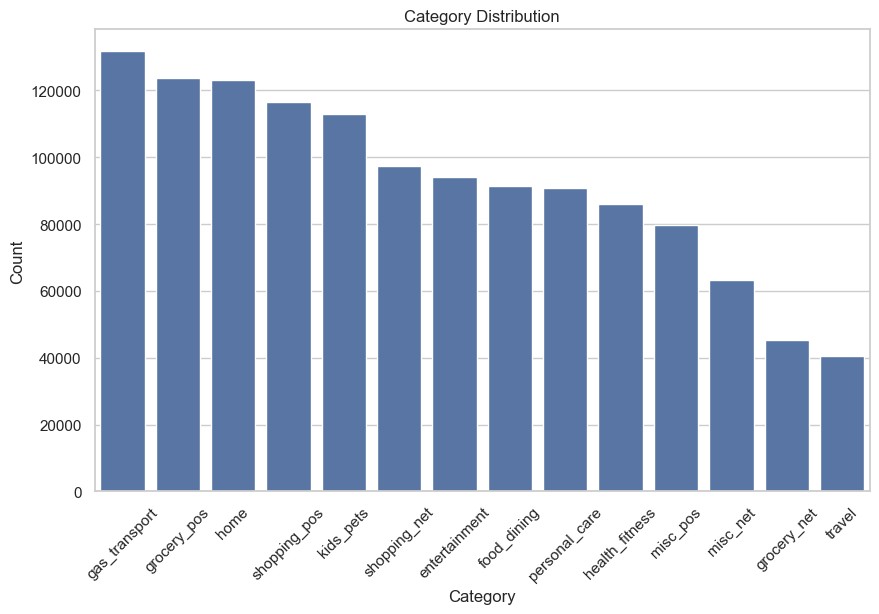

In [119]:
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45) 
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

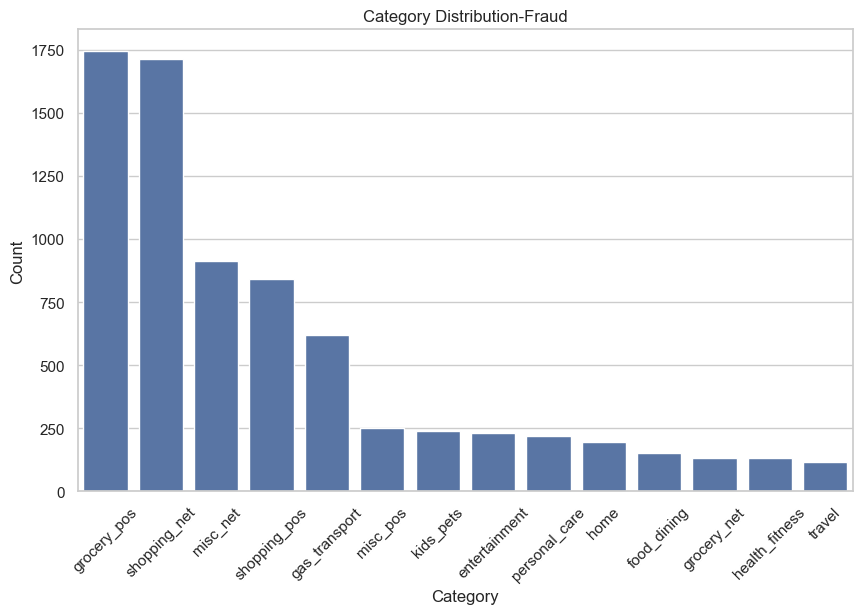

In [57]:
category_counts = df_fraud['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=45)  
plt.title('Category Distribution-Fraud')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

## Gender & Age & Job

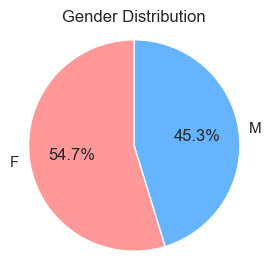

In [19]:
gender_counts = df['gender'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution')
plt.axis('equal')  
plt.show()

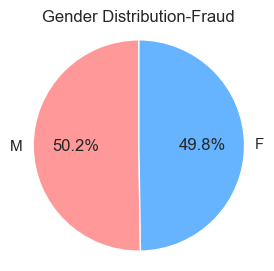

In [67]:
gender_counts = df_fraud['gender'].value_counts()

plt.figure(figsize=(3, 3))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Gender Distribution-Fraud')
plt.axis('equal')  
plt.show()

In [14]:
# define age group
bins = [0, 20, 40, 60, 80, float('inf')]
labels = ['0-20', '21-40', '41-60', '61-80', '80+']
df['age_group'] = pd.cut(df['cardholder_age'], bins=bins, labels=labels, right=False)

In [15]:
df_fraud=df[df['is_fraud']==1]

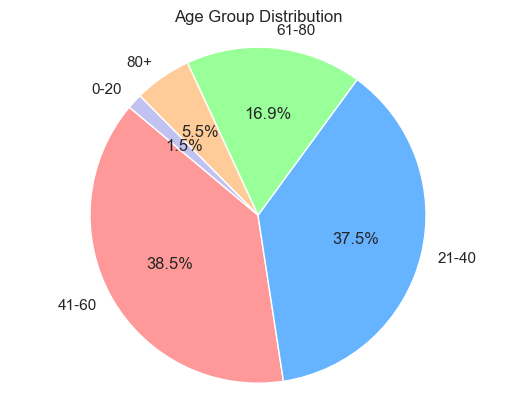

In [45]:
age_frequency = df['age_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Age Group Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

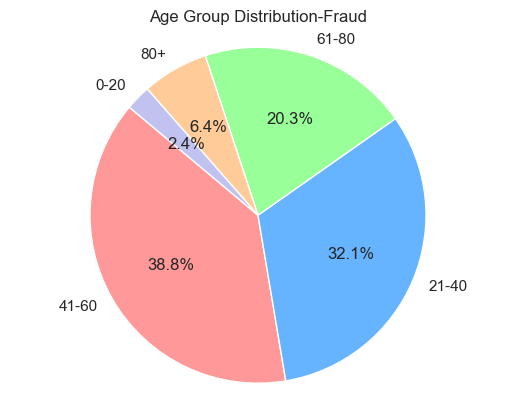

In [63]:
age_frequency = df_fraud['age_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Age Group Distribution-Fraud')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

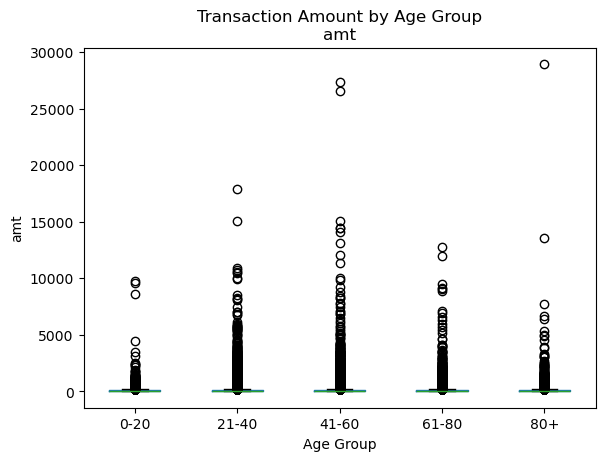

In [16]:
df.boxplot(column='amt', by='age_group', grid=False)

plt.suptitle('Transaction Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('amt')

plt.show()

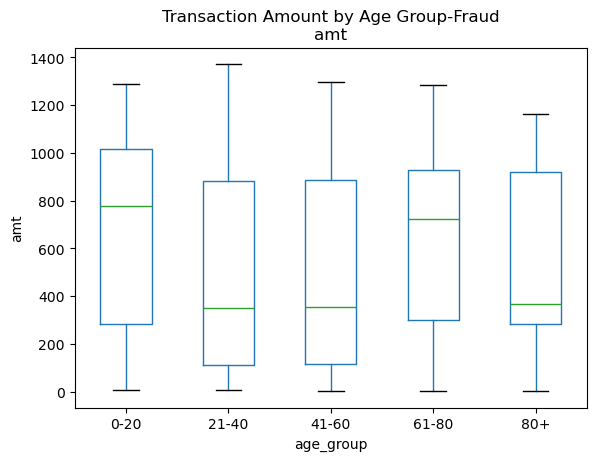

In [17]:
df_fraud.boxplot(column='amt', by='age_group', grid=False)

plt.suptitle('Transaction Amount by Age Group-Fraud')
plt.xlabel('age_group')
plt.ylabel('amt')

plt.show()

In [60]:
df['job'].value_counts()

job
Exhibition designer           6979
Designer, ceramics/pottery    6263
Systems developer             6119
Financial adviser             5887
Environmental consultant      5404
                              ... 
Ship broker                      7
Contracting civil engineer       7
Accountant, chartered            6
Forest/woodland manager          5
Air traffic controller           1
Name: count, Length: 487, dtype: int64

In [61]:
df_fraud['job'].value_counts()

job
Exhibition designer                                 43
Private music teacher                               40
Materials engineer                                  38
Prison officer                                      37
Hospital doctor                                     35
                                                    ..
Administrator, charities/voluntary organisations     1
Administrator, arts                                  1
Air traffic controller                               1
Nurse, children's                                    1
Location manager                                     1
Name: count, Length: 384, dtype: int64

## Distance

In [31]:
bins = [0, 30, 60, 90, 120, 150, float('inf')]
labels = ['0-30', '31-60', '61-90', '91-120', '121-150','150+']
df['distance_group'] = pd.cut(df['distance'], bins=bins, labels=labels, right=False)

In [32]:
df_fraud=df[df['is_fraud']==1]

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_14304\3547406154.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df.groupby(['distance_group']).size().reset_index(name='count')


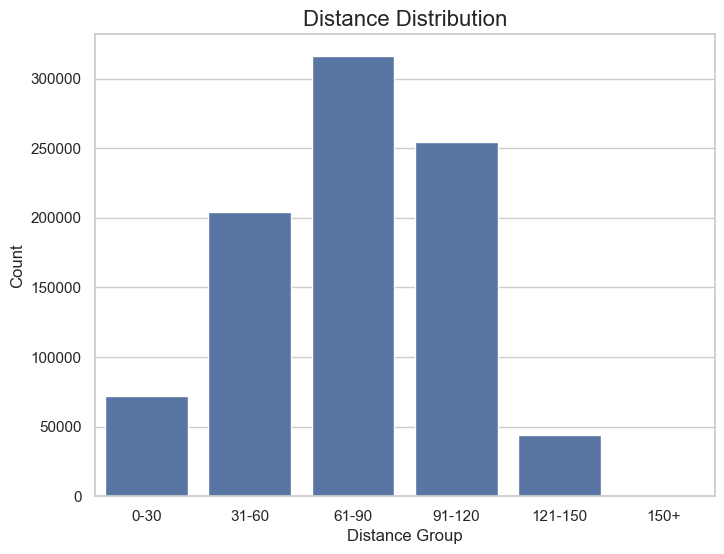

In [67]:
monthly_counts = df.groupby(['distance_group']).size().reset_index(name='count')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='distance_group', y='count', data=monthly_counts)

plt.title('Distance Distribution', fontsize=16)
plt.xlabel('Distance Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_14304\1752281133.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df_fraud.groupby(['distance_group']).size().reset_index(name='count')


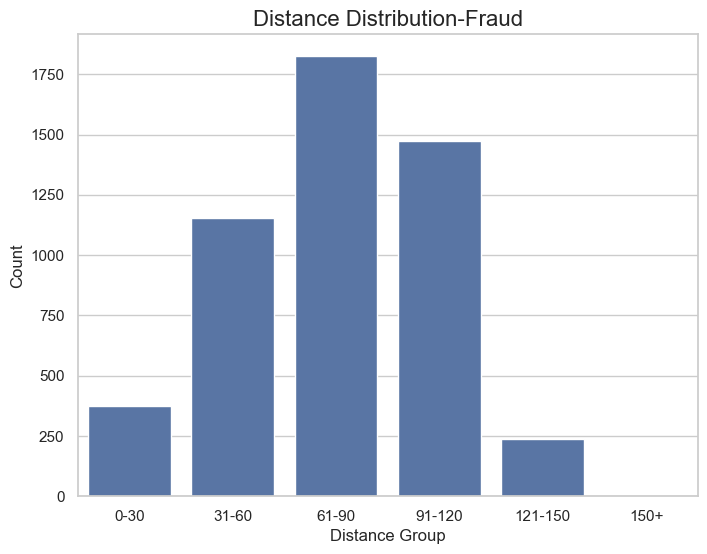

In [66]:
monthly_counts = df_fraud.groupby(['distance_group']).size().reset_index(name='count')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='distance_group', y='count', data=monthly_counts)
plt.title('Distance Distribution-Fraud', fontsize=16)
plt.xlabel('Distance Group', fontsize=12)
plt.ylabel('Count', fontsize=12)


plt.show()

## Amount

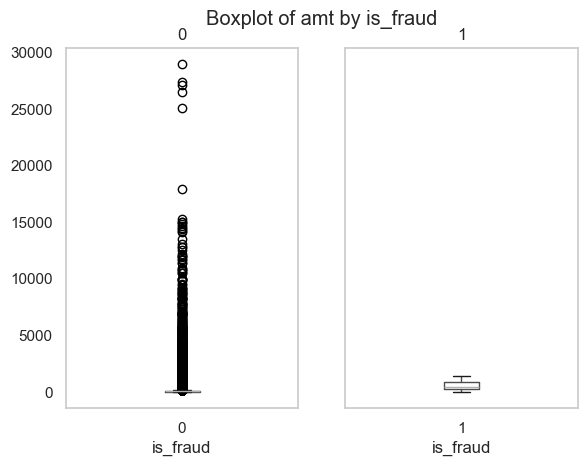

In [21]:
grouped = df.groupby('is_fraud')
grouped.boxplot(column='amt', by='is_fraud', grid=False)

plt.suptitle('Boxplot of amt by is_fraud')
plt.xlabel('is_fraud')
plt.ylabel('amt')

plt.show()

## Geographic Information - State, City， Population, Population Density

In [39]:
import geopandas as gpd
state_counts = df['state'].value_counts().reset_index()
state_counts.columns = ['state_abbr', 'count']

state_abbr_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}
state_counts['state_full'] = state_counts['state_abbr'].map(state_abbr_to_full)


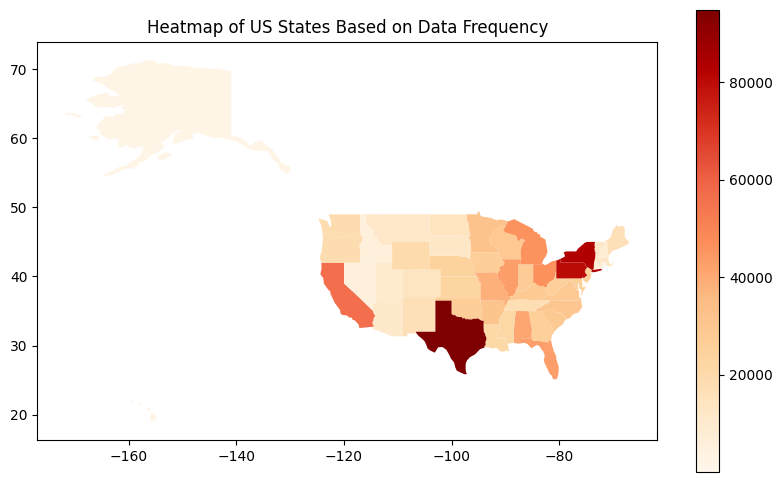

In [66]:
usa_states = gpd.read_file('./110m_cultural/ne_110m_admin_1_states_provinces.shp')

merged = usa_states.set_index('name').join(state_counts.set_index('state_full'))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column='count', ax=ax, legend=True, cmap='OrRd', missing_kwds={"color": "lightgrey"})
plt.title('Heatmap of US States Based on Data Frequency')
plt.show()

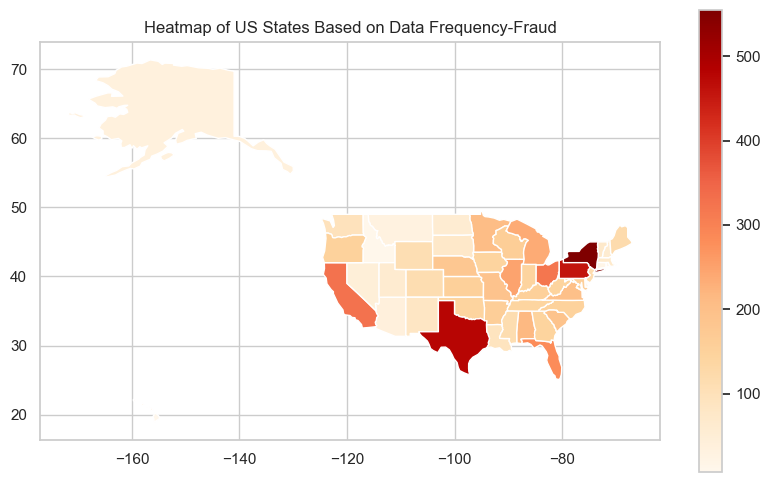

In [41]:
state_counts = df_fraud['state'].value_counts().reset_index()
state_counts.columns = ['state_abbr', 'count']
state_counts['state_full'] = state_counts['state_abbr'].map(state_abbr_to_full)

usa_states = gpd.read_file('./110m_cultural/ne_110m_admin_1_states_provinces.shp')

merged = usa_states.set_index('name').join(state_counts.set_index('state_full'))

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged.plot(column='count', ax=ax, legend=True, cmap='OrRd', missing_kwds={"color": "lightgrey"})
plt.title('Heatmap of US States Based on Data Frequency-Fraud')
plt.show()

In [23]:
df_fraud=df[df['is_fraud']==1]

In [25]:
df['merch_state'].value_counts()

merch_state
Texas                   58896
Pennsylvania            58773
New York                52970
Ohio                    37453
Illinois                32877
California              31864
Missouri                31351
Michigan                26580
Virginia                26236
Alabama                 25554
Iowa                    24845
Indiana                 24040
Arkansas                22741
West Virginia           22105
Florida                 22064
Oklahoma                21917
Georgia                 21686
North Carolina          20204
Kentucky                19846
Wisconsin               19419
Minnesota               19157
Kansas                  18937
South Carolina          18909
Mississippi             18364
Nebraska                17764
Maryland                17659
Tennessee               17370
Louisiana               13814
Washington              10689
Oregon                  10672
Colorado                 9306
North Dakota             9029
South Dakota             769

In [26]:
df_fraud['merch_state'].value_counts()

merch_state
New York          332
Pennsylvania      321
Texas             296
Ohio              224
Missouri          197
Illinois          196
Virginia          170
California        167
Michigan          163
Florida           159
Iowa              142
Alabama           140
Arkansas          124
Tennessee         123
West Virginia     122
Wisconsin         122
Georgia           115
Kentucky          115
Oklahoma          115
Indiana           115
South Carolina    111
Nebraska          110
Minnesota         109
Kansas            102
North Carolina     96
Mississippi        91
Maryland           88
Oregon             86
Colorado           64
Louisiana          54
Washington         45
South Dakota       45
New Mexico         37
Montana            27
North Dakota       27
Idaho              19
Delaware           19
Arizona            17
Wyoming            15
Nevada             15
Utah               14
Hawaii              1
Name: count, dtype: int64

In [27]:
df['merch_city'].value_counts()

merch_city
Greenville       1068
Lexington        1067
Franklin         1041
Cleveland         979
Clinton           956
                 ... 
Calexico            1
Woody               1
Grandy              1
Poplar Branch       1
Sprague River       1
Name: count, Length: 13863, dtype: int64

In [28]:
df_fraud['merch_city'].value_counts()

merch_city
Houston            16
Columbia           11
Princeton           9
Columbus            8
Lexington           7
                   ..
Rogers City         1
Easton              1
Saint Ignace        1
De Tour Village     1
Artesian            1
Name: count, Length: 3320, dtype: int64

In [29]:
df['merch_pop'].sort_values()

23025          0.0
33612          0.0
102926         0.0
6860           0.0
526616         0.0
            ...   
799166    130920.0
789025    130920.0
469907    130920.0
388476    130920.0
437309    130920.0
Name: merch_pop, Length: 820847, dtype: float64

In [31]:
df_fraud['merch_pop'].sort_values()

50571         0.0
18293         0.0
109278        0.0
124678        0.0
734237        0.0
           ...   
298058    83716.0
3997      86530.0
147356    89651.0
782229    91275.0
584896    91618.0
Name: merch_pop, Length: 4650, dtype: float64

In [42]:
bins = [0, 5000, 10000, 15000, 20000, float('inf')]
labels = ['0-5000', '5001-10000', '10001-15000', '15001-20000', '20000+']
df['merch_pop_group'] = pd.cut(df['merch_pop'], bins=bins, labels=labels, right=False)
df_fraud=df[df['is_fraud']==1]

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_32396\179902330.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df.groupby(['merch_pop_group']).size().reset_index(name='count')


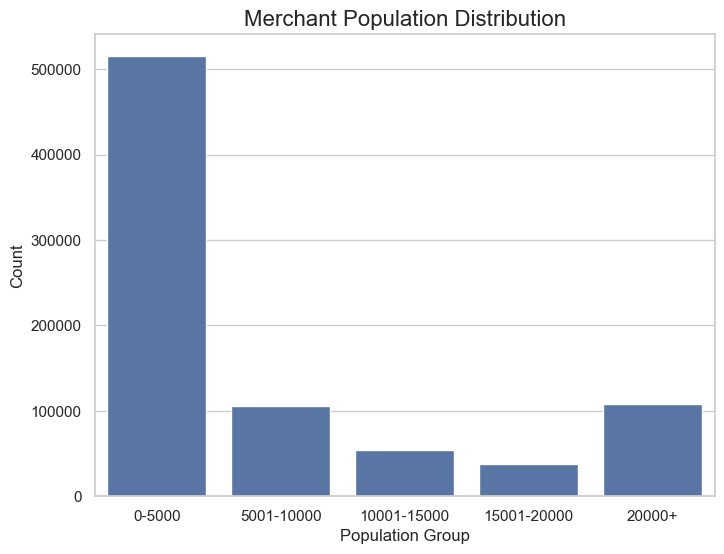

In [39]:
monthly_counts = df.groupby(['merch_pop_group']).size().reset_index(name='count')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x='merch_pop_group', y='count', data=monthly_counts)

plt.title('Merchant Population Distribution', fontsize=16)
plt.xlabel('Population Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_32396\3493289517.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df_fraud.groupby(['merch_pop_group']).size().reset_index(name='count')


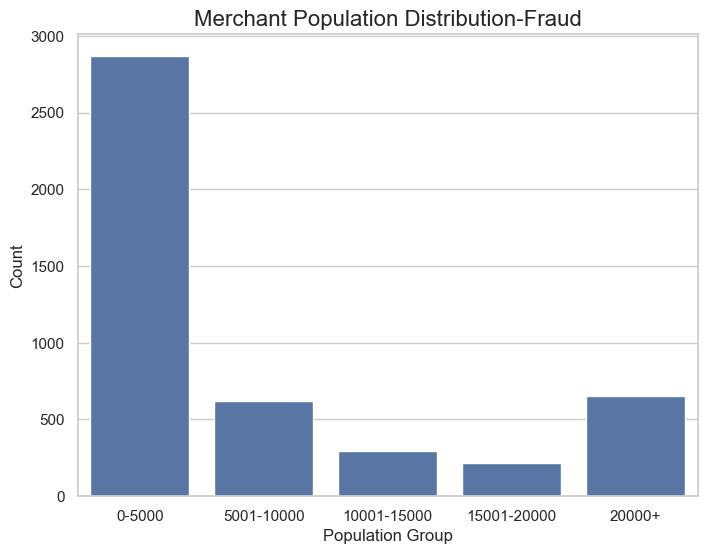

In [41]:
monthly_counts = df_fraud.groupby(['merch_pop_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(x='merch_pop_group', y='count', data=monthly_counts)

plt.title('Merchant Population Distribution-Fraud', fontsize=16)
plt.xlabel('Population Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [42]:
df['merch_dens'].sort_values()

801688        0.0
125713        0.0
301365        0.0
167652        0.0
856855        0.0
           ...   
875709    58937.6
26348     58937.6
305395    58937.6
467473    58937.6
384213    60879.2
Name: merch_dens, Length: 820847, dtype: float64

In [43]:
df_fraud['merch_dens'].sort_values()

124678        0.0
101849        0.0
85016         0.0
406424        0.0
75041         0.0
           ...   
130748     5822.1
740794     8617.4
606167    11996.4
137411    12486.2
128707    13520.9
Name: merch_dens, Length: 4650, dtype: float64

In [19]:
bins = [0, 250,500,750,1000, float('inf')]
labels = ['0-250', '250-500', '500-750','750-1000', '1000+']
df['merch_dens_group'] = pd.cut(df['merch_dens'], bins=bins, labels=labels, right=False)
df_fraud=df[df['is_fraud']==1]

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\1497542119.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df.groupby(['merch_dens_group']).size().reset_index(name='count')


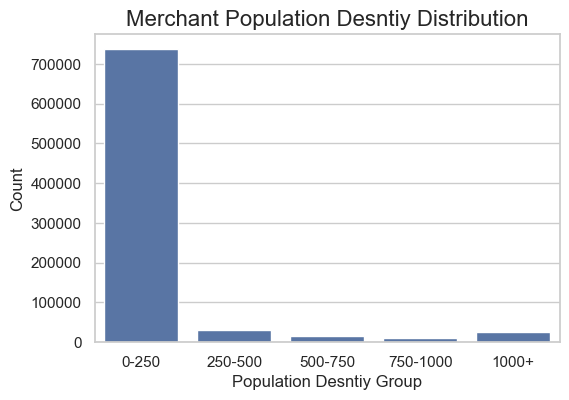

In [20]:
monthly_counts = df.groupby(['merch_dens_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x='merch_dens_group', y='count', data=monthly_counts)

plt.title('Merchant Population Desntiy Distribution', fontsize=16)
plt.xlabel('Population Desntiy Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\4100669603.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df_fraud.groupby(['merch_dens_group']).size().reset_index(name='count')


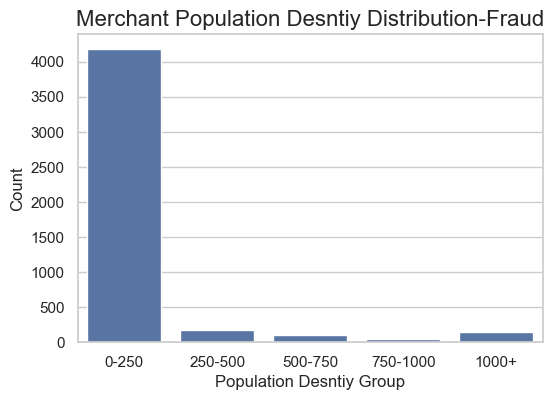

In [21]:
monthly_counts = df_fraud.groupby(['merch_dens_group']).size().reset_index(name='count')

sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x='merch_dens_group', y='count', data=monthly_counts)

plt.title('Merchant Population Desntiy Distribution-Fraud', fontsize=16)
plt.xlabel('Population Desntiy Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [64]:
df['holder_state'].value_counts()

holder_state
Texas                   61558
Pennsylvania            57939
New York                45580
Ohio                    34917
Illinois                33905
California              32105
Alabama                 31215
Missouri                30457
Michigan                26677
Arkansas                24149
North Carolina          23120
Virginia                22358
Minnesota               22030
Kentucky                21807
Iowa                    21563
Indiana                 21446
South Carolina          21171
Wisconsin               20638
West Virginia           20401
Oklahoma                20385
Florida                 20038
Georgia                 19058
Maryland                19046
Nebraska                17900
Kansas                  16935
Mississippi             16036
Louisiana               13995
Tennessee               13796
Washington              10570
Oregon                  10557
North Dakota             8565
New Jersey               8522
Colorado                 80

In [65]:
df_fraud['holder_state'].value_counts()

holder_state
Pennsylvania            314
Texas                   302
New York                297
Ohio                    247
Illinois                198
Missouri                177
California              177
Alabama                 167
Michigan                163
Florida                 157
Arkansas                141
Nebraska                138
Minnesota               138
South Carolina          134
Virginia                134
Kentucky                126
Wisconsin               124
Iowa                    118
Tennessee               112
Oklahoma                108
North Carolina          106
West Virginia           105
Maryland                105
Indiana                  90
Georgia                  84
Kansas                   77
Oregon                   76
Mississippi              67
Louisiana                62
Washington               54
Colorado                 53
South Dakota             40
New Jersey               40
New Mexico               37
North Dakota             35
Wyoming

In [62]:
df['holder_city'].value_counts()

holder_city
Birmingham      4427
Thomas          3644
San Antonio     3623
Utica           3556
Cleveland       3406
                ... 
Norfolk            4
Downey             4
Mount Vernon       2
Greenport          2
Irvington          1
Name: count, Length: 848, dtype: int64

In [63]:
df_fraud['holder_city'].value_counts()

holder_city
Dallas          27
Warren          25
Oxford          25
Detroit         24
San Antonio     22
                ..
Irvington        1
Parks            1
Paauilo          1
Powell Butte     1
Higganum         1
Name: count, Length: 540, dtype: int64

In [66]:
df['holder_pop'].sort_values()

68088          0.0
497542         0.0
539352         0.0
124663         0.0
115328         0.0
            ...   
279537    101983.0
785823    101983.0
625208    101983.0
532198    101983.0
461517    101983.0
Name: holder_pop, Length: 820847, dtype: float64

In [67]:
df_fraud['holder_pop'].sort_values()

71184         0.0
764149        0.0
764229        0.0
767120        0.0
767395        0.0
           ...   
859583    83247.0
858421    83247.0
496045    96200.0
495989    96200.0
496126    96200.0
Name: holder_pop, Length: 4650, dtype: float64

In [22]:
bins = [0, 5000, 10000, 15000, 20000, float('inf')]
labels = ['0-5000', '5001-10000', '10001-15000', '15001-20000', '20000+']
df['holder_pop_group'] = pd.cut(df['holder_pop'], bins=bins, labels=labels, right=False)
df_fraud=df[df['is_fraud']==1]

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\3655905580.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df.groupby(['holder_pop_group']).size().reset_index(name='count')


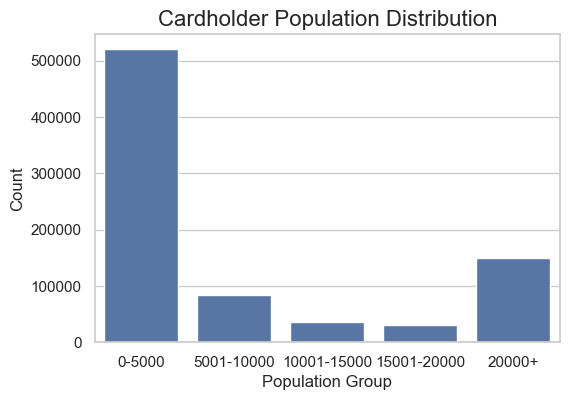

In [23]:
monthly_counts = df.groupby(['holder_pop_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x='holder_pop_group', y='count', data=monthly_counts)

plt.title('Cardholder Population Distribution', fontsize=16)
plt.xlabel('Population Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\1690801304.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df_fraud.groupby(['holder_pop_group']).size().reset_index(name='count')


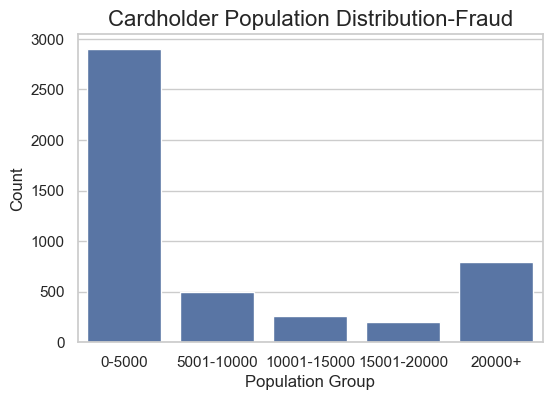

In [24]:
monthly_counts = df_fraud.groupby(['holder_pop_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x='holder_pop_group', y='count', data=monthly_counts)

plt.title('Cardholder Population Distribution-Fraud', fontsize=16)
plt.xlabel('Population Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [27]:
bins = [0, 250,500,750,1000, float('inf')]
labels = ['0-250', '250-500', '500-750','750-1000', '1000+']
df['holder_dens_group'] = pd.cut(df['holder_dens'], bins=bins, labels=labels, right=False)
df_fraud=df[df['is_fraud']==1]

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\2489080537.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df.groupby(['holder_dens_group']).size().reset_index(name='count')


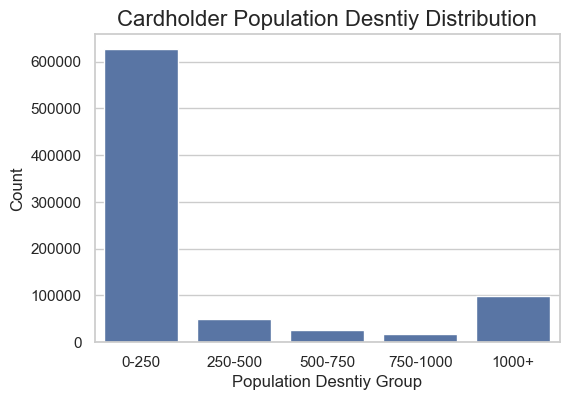

In [28]:
monthly_counts = df.groupby(['holder_dens_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x='holder_dens_group', y='count', data=monthly_counts)

plt.title('Cardholder Population Desntiy Distribution', fontsize=16)
plt.xlabel('Population Desntiy Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_12116\2233231796.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_counts = df_fraud.groupby(['holder_dens_group']).size().reset_index(name='count')


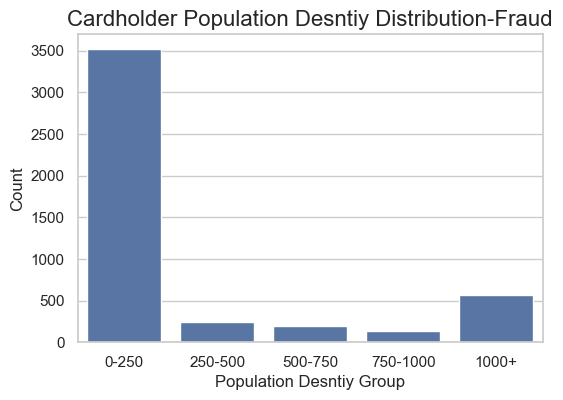

In [29]:
monthly_counts = df_fraud.groupby(['holder_dens_group']).size().reset_index(name='count')

sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(x='holder_dens_group', y='count', data=monthly_counts)

plt.title('Cardholder Population Desntiy Distribution-Fraud', fontsize=16)
plt.xlabel('Population Desntiy Group', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [30]:
correlation = df['holder_pop'].corr(df['holder_dens'])
print(f" {correlation:.2f}")

 (column1 和 column2): 0.32


In [31]:
correlation = df['merch_pop'].corr(df['merch_dens'])
print(f" {correlation:.2f}")

 0.35


In [45]:
correlation = df['merch_pop'].corr(df['holder_pop'])
print(f" {correlation:.2f}")

 0.24


In [46]:
correlation = df['merch_dens'].corr(df['holder_dens'])
print(f" {correlation:.2f}")

 0.16


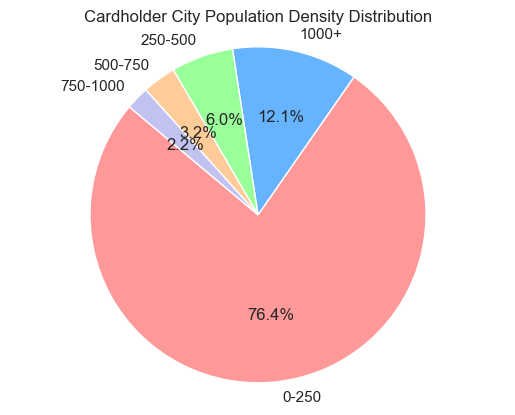

In [34]:
age_frequency = df['holder_dens_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Cardholder City Population Density Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

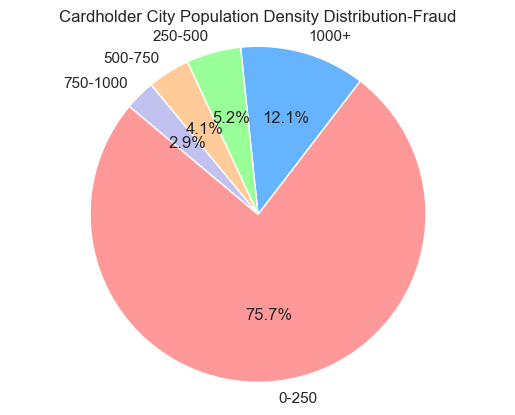

In [35]:
age_frequency = df_fraud['holder_dens_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Cardholder City Population Density Distribution-Fraud')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

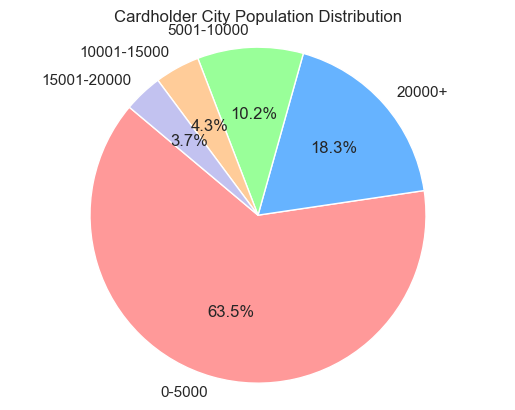

In [36]:
age_frequency = df['holder_pop_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Cardholder City Population Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

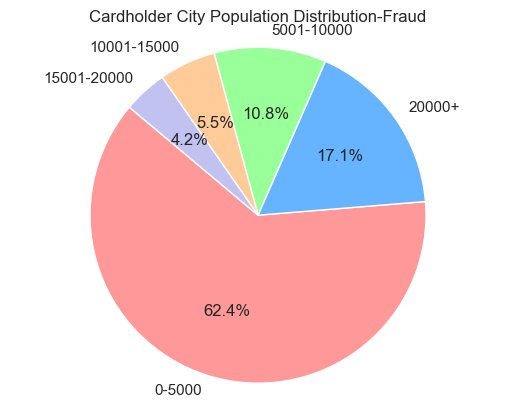

In [37]:
age_frequency = df_fraud['holder_pop_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Cardholder City Population Distribution-Fraud')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

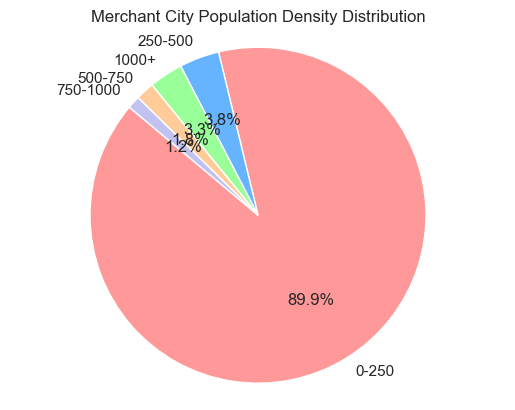

In [38]:
age_frequency = df['merch_dens_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Merchant City Population Density Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

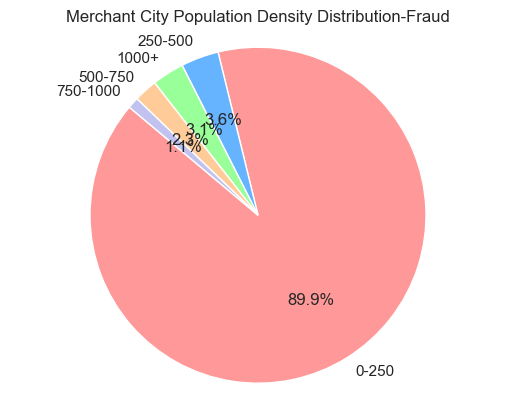

In [39]:
age_frequency = df_fraud['merch_dens_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Merchant City Population Density Distribution-Fraud')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

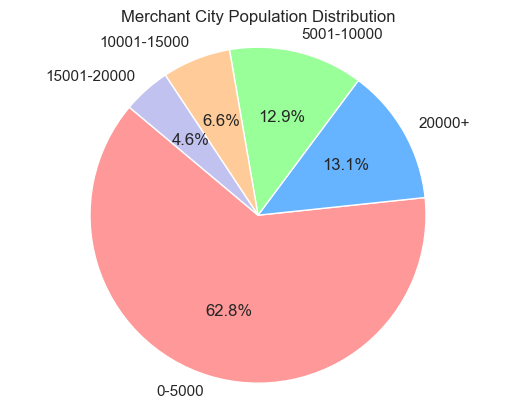

In [43]:
age_frequency = df['merch_pop_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Merchant City Population Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

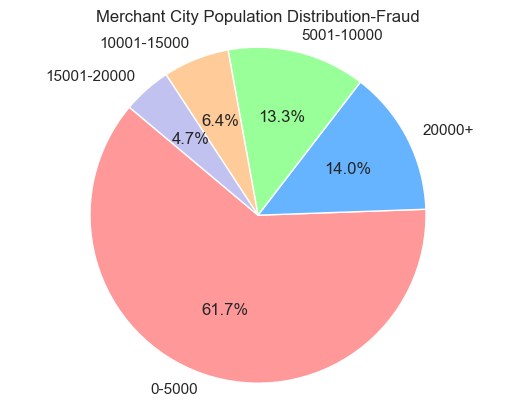

In [44]:
age_frequency = df_fraud['merch_pop_group'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

plt.pie(age_frequency, labels=age_frequency.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Merchant City Population Distribution-Fraud')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()